In [1]:
import sys
import os
import warnings

# Ajouter le répertoire parent pour inclure 'src'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

# Imports après avoir ajusté le sys.path
from src.backtester.back_tester import BackTesting
from src.strategies.strategies import *
from src.utils.utilities import Utilities
from src.performance.graph import IndexPlotter
import utils.constant as constant
from src.performance.metrics import MetricsCalculator
from datetime import datetime, date

# Supprimer les avertissements FutureWarning et RuntimeWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.float_format', '{:.3f}'.format)

<div style="background-color: rgb(15, 50, 110); color: white; padding: 15px; border-radius: 8px; box-shadow: 0 3px 6px 0 rgba(0, 0, 0, 0.2); text-align: center;">
    <h1 style="font-size: 32px; font-weight: bold; margin: 0;">Volatility Timing under Low-Volatility Strategy</h1>
</div> 

## <span style="color: rgb(15, 50, 150); font-size: 20px; font-weight: bold;"> Volatility Strategies </span>

In [2]:
# Data import
asset_indices_monthly = Utilities.load_asset_indices(["LowVolatilityDecile", "VolatilityTiming", 
                                                      "HighVolatilityDecile"], 
                                                    folder_subpath="asset_indices\\monthly_eq_weighted")

asset_indices_monthly_all = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile", 
                                                          "HighVolatilityDecile", "VolatilityTiming", 
                                                          "VolatilityTiming2sided"], 
                                                          folder_subpath="asset_indices\\monthly_eq_weighted")

other_data = Utilities.get_data_from_pickle('other_US_data', folder_subpath="universe")

# Parameters
risk_free_rate_ticker = "US0003M Index"
ticker = "RIY INDEX"
start_date = datetime(2000, 1, 31)
end_date = datetime(2024, 2, 29)
frequency = "monthly"


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;"> 1. Volatility and Return Profile under Different Market Conditions </span>

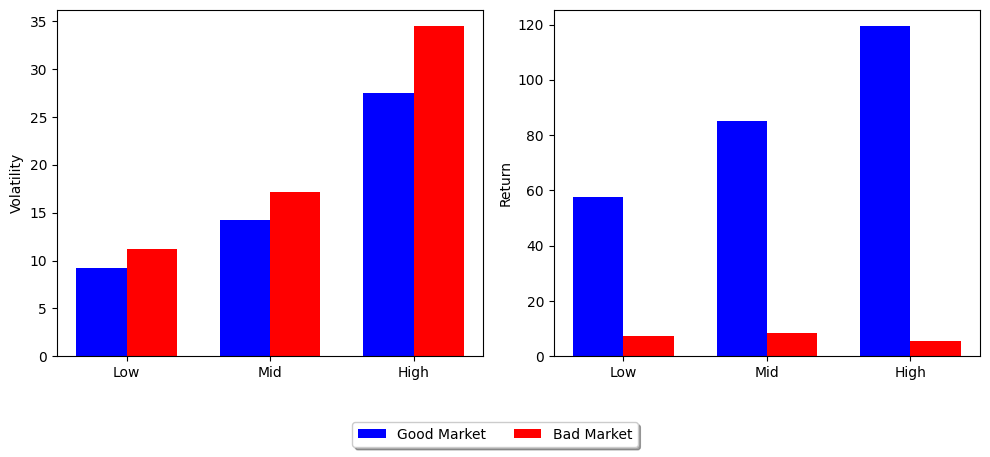

In [3]:
# Filtering asset indices
asset_indices = {ticker :item for ticker, item in asset_indices_monthly_all.items() if ticker in 
                 ["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile"]}

# Plot asset indices under different conditions
IndexPlotter.asset_indices_plot_under_diff_conditions(asset_indices, other_data, risk_free_rate_ticker,
                                                      start_date, end_date,
                                                      frequency, constant.REBALANCING_MOMENT, ticker)

**Commentaire** :
+ La volatilité des différents portefeuilles est plus élevée dans des mauvaises conditions de marché que dans des bonnes
+ Que les conditions de marché soient bonnes ou mauvaises, la volatilité augmente lorsqu'on passe des déciles les plus faibles aux plus élevés
+ Les actions peu volatiles sont plus performantes en cas de bonne conjoncture
+ En revanche, en cas de mauvaise conjoncture, les actions à volatilité moyenne surperforment celles très peu volatiles et les titres les plus volatils affichent le rendement le plus fiable

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;"> 2. Performance and Wealth Plots of the Volatility Strategies </span>

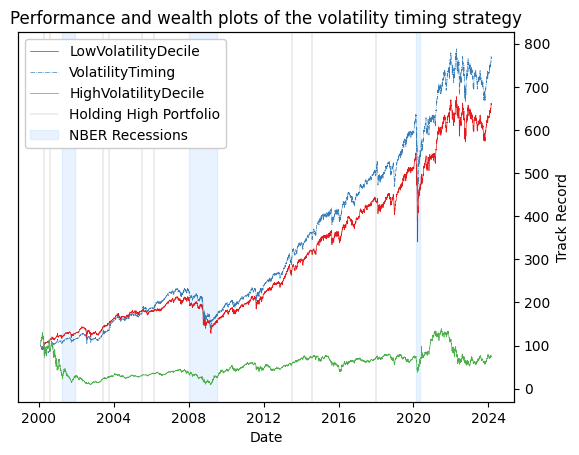

In [4]:
# Graph des tracks records Vol Timing
IndexPlotter.plot_track_records(asset_indices_monthly, other_data['USRINDEX Index'])

**Commentaire**

+ Le graphique de la richesse cumulée montre clairement que la stratégie de  timing de volatilité a une trajectoire très proche de celle du portefuille à faible volatilité (***LowDecile***), car ce dernier a été détenu la majorité du temps.
+ La stratégie de ***VolTiming*** permet de génerer un rendement excédentaire par rapport à la strategie ***LowVolatility*** en bénéficiant du rendement plus élevé du portefeuille à forte volatilité (***HighVolatility***) lorsque les conditions de marché sont favorables
+ Seulement quelques changements de portefeuille sur l'ensemble de la période de backtest permettent de générer ce rendement excédentaire

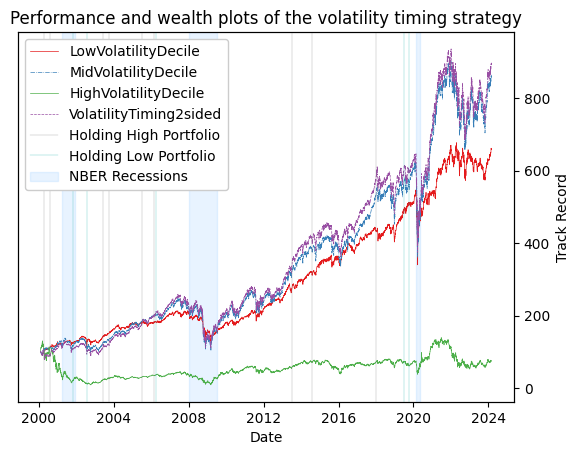

In [5]:
# Graph des tracks records des stratégies
asset_indices = {ticker :item for ticker, item in asset_indices_monthly_all.items() if ticker in 
                 ["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming2sided"]}

IndexPlotter.plot_track_records(asset_indices, other_data['USRINDEX Index'])

**Commentaire**

+ La détention du portefeuille de volatilité moyenne (***MidVolatiity***) permet surperformer la stratégie ***VolTiming***. Ce constat justifie la création d'une version améliorée de la stratégie de timing de volatilité : la stratégie ***VolTiming2sided***.

+ La stratégie ***VolTiming2sided*** permet d'obtenir  un rendement supérieur à toutes les stratégies présentées jusqu'à présent : 

    - Comme pour la stratégie de ***VolTiming*** simple les trajectoires de richesse cumulée du portefeuille à volatilité moyenne et du portefeuille *2sided* sont extrêmement proches, puisque la stratégie *2sided* revient à détenir le ***MidVolatility*** la plus part du temps. De ce fait, la détention du portefeuille ***MidVolatility*** explique en grand partie la surperformance de cette stratégie de timing de volatilité par rapport aux autres. 
    - la détention du portefeuille ***HighVolatility*** en cas de bonne conjecture, permet de bénéficier du rendement élevé des titres les plus volatiles en période de forte croissance.
    - la détention du portefeuille ***LowVolatility*** en cas de mauvaise conjecture, permet d'améliorer davantage l'exposition au risque et le rendement de la stratégie. 


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  4. Performance and Risk Measures of the Various Volatility Portfolios </span>

In [6]:
IndexPlotter.disp_switch_stats(asset_indices_monthly, other_data, risk_free_rate_ticker)

,Correct Switches,Wrong Switches,Total Switches
Percentage,88.9%,11.1%,Low-/High-vol split: 97%/3%
Total Return Out Performance,47.7%,-19.8%,


+ La stratégie ***VolTiming*** consiste à détenir le décile à faible volatilité 97 % du temps. Le passage au portefeuille à forte volatilité dans 3 % des cas permet de générer une performance supplémentaire.
+ Sur toute la période du backtest, on constate que le passage au portefeuille à forte volatilité est correct dans 88,9 % des cas. Autrement dit, dans ces situations, le portefeuille à forte volatilité surperforme celui de base. Ces signaux corrects permettent de générer une surperformance totale de 47,7 % sur la période (sur-rendement mensuel). En revanche, dans 11 % des cas, le signal conduit à une sous-performance, se traduisant par un rendement total de -19,8 %. 
+ Finalement, même si le signal est erroné dans 11 % des cas, la surperformance de 47,7 % compense largement la sous-performance de -19,8 %, ce qui rend la stratégie globalement profitable.

In [7]:
asset_indices = {ticker :item for ticker, item in asset_indices_monthly_all.items() if ticker in 
                 ["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming2sided"]}

IndexPlotter.disp_switch_stats(asset_indices, other_data, risk_free_rate_ticker)

,Correct Switches,Wrong Switches,Total Switches
Percentage,71.4%,28.6%,Low-/Mid-/High-vol split: 2%/95%/3%
Total Return Out Performance,38.9%,-21.2%,


+ Dans le cadre de notre backtest, la stratégie ***VolTiming2sided*** consiste à détenir le décile à volatilité moyenne 95 % du temps, le décile à faible volatilité 2 % du temps, et le décile à forte volatilité 3 % du temp

+ Sur l'ensemble de la période du backtest, les changements de portefeuille s'avèrent corrects dans 71,4 % des cas, tandis que 28,6 % des changements sont incorrects. Les signaux corrects  générent une surperformance totale de 38,9 %, tandis que les mauvais changements  entraînent une sous-performance de -21,2 %. 

+ Finalement, le bilan global reste positif, car la surperformance de 38,9 % compense largement la sous-performance de -21,2 %

In [8]:
perf_metrics_df = IndexPlotter.display_asset_indices_metrics(asset_indices_monthly_all, 
                                                             other_data,risk_free_rate_ticker)
perf_metrics_df

,Low Volatility,Mid Volatility,High Volatility,Volatility Timing,Volatility Timing 2-sided
Total Return,559.79%,764.51%,-24.10%,667.51%,797.90%
Annualized Return,8.77%,11.10%,7.53%,9.57%,11.40%
Annualized Volatility,13.55%,20.60%,41.70%,14.74%,21.25%
Monthly Volatility,3.91%,5.95%,12.04%,4.25%,6.14%
Daily Volatility,0.85%,1.30%,2.63%,0.93%,1.34%
Sharpe Ratio,0.586,0.499,0.161,0.593,0.497
Max Drawdown,-39.98%,-57.78%,-93.28%,-39.98%,-57.78%
SQRT (Semi-variance),11.23%,16.24%,30.20%,12.56%,16.98%
Sortino Ratio,0.707,0.633,0.222,0.696,0.623
Information Ratio,Benchmark,3.933,-0.277,3.851,3.942


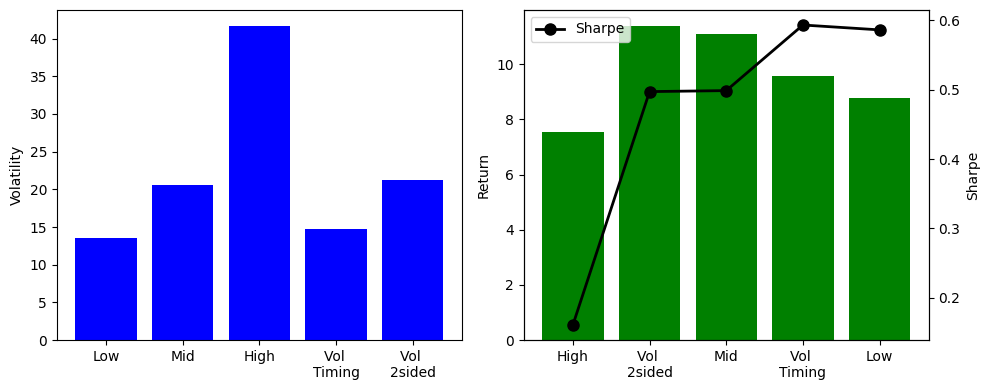

In [9]:
IndexPlotter.asset_indices_barplot(asset_indices_monthly_all, other_data, risk_free_rate_ticker)

**Commentaire**

+ Le portefeuille des titres les plus volatiles est à la fois le moins performant est le plus risqué
+ La stratégie ***Vol2sided***  affiche le rendement cumulée le plus élevé (797.90%). Cette stratégie surpasse non seulement les portefeuilles à faible et moyenne volatilité, mais aussi le strétgie base de timing de volatilité. Néammoins, le fait de détenir des actions à plus forte volatilité à cértaines périodes, font inévitablement baisser le ratio de Sharpe (0.497 contre 0.499 et 0.586 respectivement pour les stratégies ***LowVolatility*** et ***MidVolatility***)
+ La stratégie avec le meilleur rendement corrigée du risque est la stratégie ***VolTiming***
+ Les stratégies de timing de volatilité ameliorent le rendement du portefuille de base (la stratégie ***Vol2sided*** affiche par exemple un rendement annualisée de 11.40% contre 11.1% de rendement pour la startégie ***MidVolatility***), mais le risque est plus important.
+ Le drawdown maximal est le plus faible pour le portefeuille à faible volatilité et la stratégie Volatility Timing (-39,98 %), et le plus élevé pour le portefeuille à forte volatilité (-93,28 %).
+ Les ratios d'information montrent que les stratégies ***Volatility Timing*** (3.851) surpasse largement le benchmark (c'est-à-dire le portefuille ***LowVolatility***), tandis que le portefeuille à forte volatilité est en sous-performance (-0.277).

Finalement, la stratégie ***VolTiming2sided*** offre la meilleure rentabilité brute, tandis que la stratégie ***VolatilityTiming*** est la plus efficace lorsqu'on prend en compte le risque, offrant une performance corrigée du risque supérieure.

## <span style="color: rgb(15, 50, 150); font-size: 20px; font-weight: bold;"> Robustness Tests </span>


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  1. CAPM and Fama–French Alphas </span>

In [10]:
CPAM_stats, FF_stats = IndexPlotter.display_regress_statistics(asset_indices_monthly_all)
CPAM_stats

,α (%),β_mkt,R²
LowVol,0.411**,0.505**,0.529
,(2.901),(9.639),
MidVol,0.297*,1.002**,0.801
,(1.697),(16.907),
HighVol,-0.644*,2.091**,0.676
,(-1.689),(13.430),
VolTiming,0.445**,0.567**,0.501
,(2.702),(11.200),
Vol2Sided,0.303,1.040**,0.780
,(1.580),(18.942),


In [11]:
FF_stats

,α (%),β_mkt,β_SMB,β_HML,R²
LowVol,0.374**,0.546**,-0.190**,0.208**,0.627
,(3.437),(12.823),(-3.704),(3.343),
MidVol,0.217*,1.014**,-0.024,0.403**,0.877
,(1.882),(28.013),(-0.215),(6.119),
HighVol,-0.636*,1.894**,0.997**,-0.171,0.751
,(-1.928),(12.747),(6.876),(-0.897),
VolTiming,0.414**,0.601**,-0.157**,0.172**,0.552
,(2.991),(12.342),(-3.007),(2.560),
Vol2Sided,0.228*,1.045**,0.011,0.370**,0.837
,(1.707),(21.634),(0.099),(5.941),


**Commentaire**

+ L'ensemble des betas sont globalement significatifs - à l'exception de la stratégie ***MidDecile*** et ***Vol2Sided*** pour lesqeulles le facteur *Size (SMB)* n'est pas une source de rendement significative 

+ Les betas des stratégies de volatilité sont encadrés par les betas des déciles utilisés dans la construction de la stratégie de timing de volatilité : par exemple le betas du ***VolTiming*** est compris entre celui du ***HighDecile*** et celui du ***LowDecile***  

+ Les alphas sont globalement tous significativement différents de zéro, impliquant que la performance des stratégies des timing de volatilité n'est pas entièrement expliqué  par le portefeuille de marché et les facteurs de Fama-French
+ Il y aurait ainsi un facteur supplémentaire - le bon timing d'exposition au risque - permettant d'expliquer cette source de rendement.

   


### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  2. Performance plots for various rebalancing frequencies </span>

In [12]:
# Chargement des indices
asset_indices_quaterly = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile", "HighVolatilityDecile", 
                                              "VolatilityTiming", "VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\quarterly_eq_weighted")
asset_indices_semiannually = Utilities.load_asset_indices(["VolatilityTiming"],
                                             folder_subpath="asset_indices\\semiannually_eq_weighted")
asset_indices_annually = Utilities.load_asset_indices(["VolatilityTiming"],
                                             folder_subpath="asset_indices\\annually_eq_weighted")

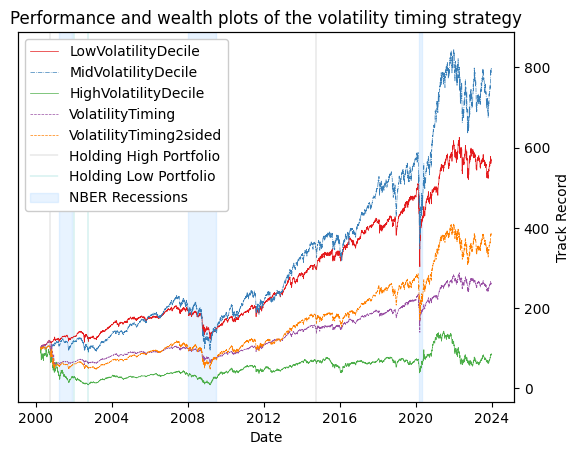

In [13]:
# Graph des tracks records des stratégies : rebalancement trimestriel (fin trimestre)
IndexPlotter.plot_track_records(asset_indices_quaterly, other_data['USRINDEX Index'])

**Commentaire**

Les stratégies de timing de volatilité ne sont pas robustes à un changement de fréquence de rebalancement. En particulier, dans le cas d'un rebalancement trimestriel, les stratégies ***VolTiming*** et ***Vol2sided*** parviennent à surperformer uniquement le décile à forte volatilité. Le portefeuille à volatilité moyenne affiche la meilleure performance cumulée.   

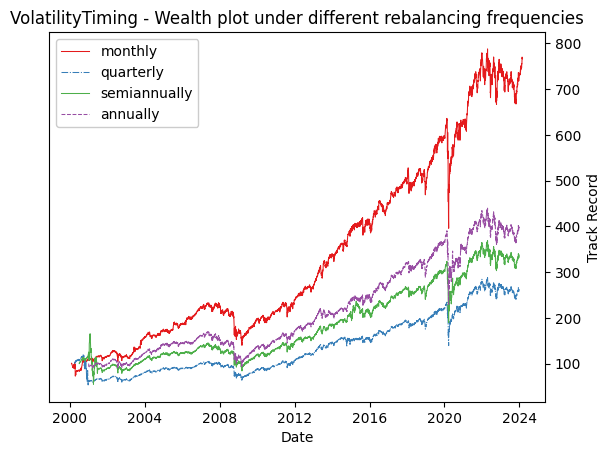

In [14]:
# Graphique des tracks records de la stratégie VolTiming pour différentes fréquences de rebalancement
IndexPlotter.plot_tracks_general( [asset_indices_monthly['VolatilityTiming'],
                                    asset_indices_quaterly['VolatilityTiming'],
                                    asset_indices_semiannually['VolatilityTiming'],
                                    asset_indices_annually['VolatilityTiming']],
                                    label_names=["monthly", "quarterly","semiannually","annually"],
                                    graph_title="VolatilityTiming - Wealth plot under different rebalancing frequencies")

Toute chose égale par ailleurs, un changement de fréquence de rebalancement, réduit fortement la performance cumulée de la stratégie de timing de volatilité. En particulier, il semblerait que plus la fréquence de rebalancement est grande moins la stratégie est performante. Cependant le rebalancement mensuel ne respecte pas ce constat : changer la composition tous le mois permet d'obtenir un rendement bien plus important. 

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  3. Performance under transaction costs </span>

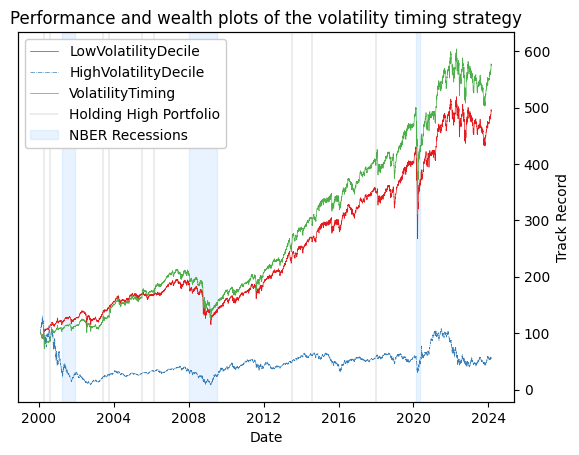

In [15]:
asset_indices_with_tc = Utilities.load_asset_indices(["LowVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming"],
                                             folder_subpath="asset_indices\\monthly_with_transaction_costs")

asset_indices_with_tc_all = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile","HighVolatilityDecile",
                                                           "VolatilityTiming","VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\monthly_with_transaction_costs")

IndexPlotter.plot_track_records(asset_indices_with_tc, other_data['USRINDEX Index'])

In [16]:
perf_metrics_with_tc_df = IndexPlotter.display_asset_indices_metrics(asset_indices_with_tc_all, 
                                                                     other_data, risk_free_rate_ticker)

IndexPlotter.display_joint_metrics(perf_metrics_df, perf_metrics_with_tc_df, 
                                   label_names=['High Volatility','Low Volatility','Volatility Timing'],
                                   column_names=["Without TC", "With TC"])

High Volatility          Low Volatility             \
                           Without TC  With TC     Without TC    With TC   
Total Return                  -24.10%  -43.13%        559.79%    394.17%   
Annualized Return               7.53%    6.33%          8.77%      7.57%   
Annualized Volatility          41.70%   41.70%         13.55%     13.55%   
Monthly Volatility             12.04%   12.04%          3.91%      3.91%   
Daily Volatility                2.63%    2.63%          0.85%      0.85%   
Sharpe Ratio                    0.161    0.132          0.586      0.497   
Max Drawdown                  -93.28%  -93.71%        -39.98%    -41.17%   
SQRT (Semi-variance)           30.20%   30.17%         11.23%     11.21%   
Sortino Ratio                   0.222    0.182          0.707      0.601   
Information Ratio              -0.277   -0.237      Benchmark  Benchmark   
Historical VaR (95%)           -4.07%   -4.07%         -1.20%     -1.20%   

                      Volatility Timing           
                             Without TC  With TC  
Total Return                    667.51%  474.86%  
Annualized Return                 9.57%    8.37%  
Annualized Volatility            14.74%   14.74%  
Monthly Volatility                4.25%    4.25%  
Daily Volatility                  0.93%    0.93%  
Sharpe Ratio                      0.593    0.512  
Max Drawdown                    -39.98%  -41.17%  
SQRT (Semi-variance)             12.56%   12.54%  
Sortino Ratio                     0.696    0.601  
Information Ratio                 3.851    4.099  
Historical VaR (95%)             -1.24%   -1.24%

**Commentaire**

Les stratégies de timing de volatilités sont robustes à l'ajout de cout de transaction, dans la mesure ou leurs indicateurs de performance restent supérieures à ceux des stratégies consistant à détenir simplement les différents déciles de volatilités.

### <span style="color: rgb(15, 50, 150); font-size: 16px; font-weight: bold;">  4. Performance under different weighting choices </span>

In [17]:
# Data import
asset_indices_vol_scaling= Utilities.load_asset_indices(["LowVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming"],
                                             folder_subpath="asset_indices\\monthly_vol_scaling")

asset_indices_vol_scaling_all= Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile","HighVolatilityDecile",
                                                           "VolatilityTiming","VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\monthly_vol_scaling")

asset_indices_max_div = Utilities.load_asset_indices(["LowVolatilityDecile", "HighVolatilityDecile", "VolatilityTiming"],
                                             folder_subpath="asset_indices\\monthly_max_div")


asset_indices_max_div_all = Utilities.load_asset_indices(["LowVolatilityDecile", "MidVolatilityDecile","HighVolatilityDecile",
                                                           "VolatilityTiming","VolatilityTiming2sided"],
                                             folder_subpath="asset_indices\\monthly_max_div")

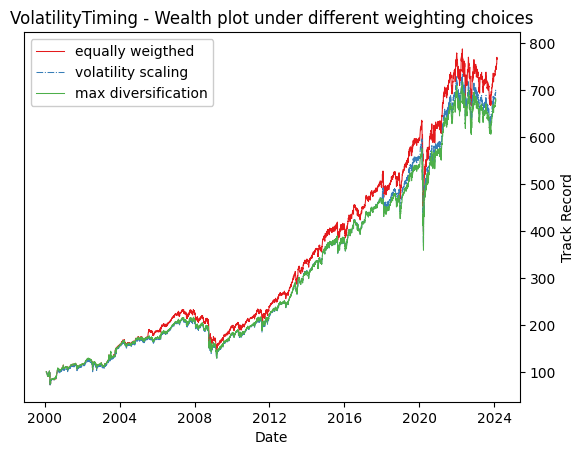

In [21]:
# Graphique des tracks records de la stratégie VolTiming pour différentes méthodes de calcul de poids
IndexPlotter.plot_tracks_general( [asset_indices_monthly_all['VolatilityTiming'],
                                    asset_indices_vol_scaling['VolatilityTiming'],
                                    asset_indices_max_div['VolatilityTiming']],
                                    label_names=["equally weigthed", "volatility scaling","max diversification"],
                                    graph_title="VolatilityTiming - Wealth plot under different weighting choices")

In [22]:
perf_metrics_vol_scaling_df = IndexPlotter.display_asset_indices_metrics(asset_indices_vol_scaling_all, 
                                                                     other_data, risk_free_rate_ticker)

perf_metrics_max_div_df = IndexPlotter.display_asset_indices_metrics(asset_indices_max_div_all, 
                                                                     other_data, risk_free_rate_ticker)

In [23]:
IndexPlotter.display_joint_metrics(perf_metrics_df, perf_metrics_vol_scaling_df,  perf_metrics_max_div_df,
                                   label_names=['High Volatility','Low Volatility','Volatility Timing'],
                                   column_names=["equally weigthed", "volatility scaling","max diversification"])

High Volatility                                         \
                      equally weigthed volatility scaling max diversification   
Total Return                   -24.10%            -60.18%             -35.76%   
Annualized Return                7.53%              5.60%               6.75%   
Annualized Volatility           41.70%             43.53%              41.51%   
Monthly Volatility              12.04%             12.57%              11.98%   
Daily Volatility                 2.63%              2.74%               2.62%   
Sharpe Ratio                     0.161              0.110               0.143   
Max Drawdown                   -93.28%            -94.01%             -94.17%   
SQRT (Semi-variance)            30.20%             31.17%              30.01%   
Sortino Ratio                    0.222              0.153               0.197   
Information Ratio               -0.277             -1.064              -0.550   
Historical VaR (95%)            -4.07%             -4.23%              -4.08%   

                        Low Volatility                                         \
                      equally weigthed volatility scaling max diversification   
Total Return                   559.79%            555.87%             533.02%   
Annualized Return                8.77%              8.80%               8.63%   
Annualized Volatility           13.55%             13.77%              13.56%   
Monthly Volatility               3.91%              3.98%               3.91%   
Daily Volatility                 0.85%              0.87%               0.85%   
Sharpe Ratio                     0.586              0.579               0.575   
Max Drawdown                   -39.98%            -40.27%             -40.34%   
SQRT (Semi-variance)            11.23%             11.42%              11.24%   
Sortino Ratio                    0.707              0.698               0.694   
Information Ratio            Benchmark          Benchmark           Benchmark   
Historical VaR (95%)            -1.20%             -1.22%              -1.20%   

                      Volatility Timing                                         
                       equally weigthed volatility scaling max diversification  
Total Return                    667.51%            593.52%             575.80%  
Annualized Return                 9.57%              9.21%               9.07%  
Annualized Volatility            14.74%             14.98%              14.78%  
Monthly Volatility                4.25%              4.32%               4.27%  
Daily Volatility                  0.93%              0.94%               0.93%  
Sharpe Ratio                      0.593              0.560               0.558  
Max Drawdown                    -39.98%            -40.27%             -40.34%  
SQRT (Semi-variance)             12.56%             12.76%              12.56%  
Sortino Ratio                     0.696              0.657               0.657  
Information Ratio                 3.851              2.818               2.928  
Historical VaR (95%)             -1.24%             -1.27%              -1.25%

+ La startégie de de timing de volatilité est robuste au choix de la méthode utilisée pour les calculs des poids, dans la mésure ou le portefuille ***VolTiming*** sur-performe le portefuille de base de la stratégie (***LowVolatility***).

+ La méthode 'equally weighted' pour la détermination des poids offre globalement de meilleures performances et un niveau de risque plus faible.